# A distance based method to find the periodic genes

## Author: Huarui Zhou, hz226@duke.edu
## 11/3/2023

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import seaborn as sns
import matplotlib
import scipy

In [2]:
#distance metrics
def Euclidean(list1,list2):
    Len = len(list1)
    Dist = np.sqrt(sum([(list1[i]-list2[i])**2 for i in range(Len)]))
    return Dist

In [3]:
#function to perform MaxMin normalization, all time points will be scaled to the range [-1,1]
def MaxMinNorm(List):
    Min = min(List)
    Max = max(List)
    if Max == Min: 
        List_normalized = List
    else:    
        List_normalized = [((i-Min)/(Max-Min)-0.5)*2 for i in List]
    return List_normalized

In [4]:
#function to plot the heatmap
norm = matplotlib.colors.Normalize(-3,3)
colors = [[norm(-3), "cyan"],
          [norm(0), "black"],
         [norm(3), "yellow"]]
haase = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

def heatmap_order(data, order, z_score_norm = True, yticks = False, cbar_bool = True, axis = None, scale_min = -1.5, scale_max = 1.5):
    # data = data frame with gene names as the index
    #order = list of genes to plot in desired order

    # yticks: default False doesn't plot ytick labels
    # cbar_bool: default True does include color bar
    # axis: default None doesn't specify an axis
    data.index.name = None
    data = data.loc[order]
    if z_score_norm == True:
        norm_data = scipy.stats.zscore(data, axis=1)
    else:
        norm_data = data
    norm_data_df = pd.DataFrame(norm_data, index=data.index, columns=data.columns)
    order2 = norm_data_df.index
    s = sns.heatmap(norm_data_df, cmap=haase, vmin=scale_min, vmax=scale_max, yticklabels = yticks, cbar= cbar_bool,ax = axis)
    return

In [5]:
#function to find the periodic genes
#Input: 
#DataFrame: the time series table
#period: the period of the time series
#bin_time: peak time gap between two nearby reference cosine curves
#Output: result data frame and mean distance. 
def Get_peak_time_and_distance(DataFrame, period, bin_time):
    DataFrame1 = DataFrame.copy()
    DataFrame1 = DataFrame1.dropna()
    DataFrame2 = DataFrame1.copy()
   
    #MaxMin normalize time series curve
    for i in list(DataFrame1.index):
        y = list(DataFrame1.loc[i])
        y = MaxMinNorm(y)
        DataFrame2.loc[i] = y
        
    time = np.asarray([float(i) for i in list(DataFrame1.T.index)])  
    
    #generate reference cosine curves
    a = 2*np.pi/period
    ref_num = int(period/bin_time)
    ref_list = [np.cos(a*time-bin_time*a*i) for i in range(ref_num)]
    
    #convert time series table into a dictionary {gene:[expression list]}
    TS_Dict = {}
    for i in range(len(DataFrame2)):
        TS_Dict[DataFrame2.index[i]] = DataFrame2.loc[DataFrame2.index[i], :].values.flatten().tolist()
    
    #create the result data frame
    Result_DF = pd.DataFrame(index=DataFrame1.index,columns=['peak_time', 'Distance'])
    
    #For each gene, calculate its distance to all reference cosine curves and then find the closest ref curve
    #record two scores into the result table: 
    #'Distance', the distance to its closest ref curve; 
    #'peak_time', the first peak time of its closest ref curve
    
    for key in TS_Dict.keys():
        Dict_list = [[Euclidean(TS_Dict[key],ref_list[i]),i] for i in range(len(ref_list))]
        Dict_list.sort(key = lambda x:x[0])
        Result_DF.loc[key]['peak_time'] = float(Dict_list[0][1])*bin_time
        Result_DF.loc[key]['Distance'] = float(Dict_list[0][0])
    
    Result_DF[['peak_time', 'Distance']] = Result_DF[['peak_time', 'Distance']].apply(pd.to_numeric)
    Result_DF = Result_DF.sort_values(by=['Distance'])
    
    return Result_DF,Result_DF['Distance'].mean()

## Example: S. cerevisiae dataset

In [6]:
#import the time series table
df_sc = pd.read_csv('WT_cleaned.csv',sep='\t', header= 0, index_col = 'Genes')

In [7]:
print(df_sc)

               0      5     10     15     20      25     30      35     40  \
Genes                                                                        
ETS1-1     73.98  30.38  26.89  28.15  21.54   22.53  27.07   34.20  22.78   
ETS1-2     73.98  30.38  26.89  28.15  21.54   22.53  27.07   34.20  22.78   
ICR1        3.72   5.23   2.75   2.80   2.96    4.36   3.81    3.79   3.54   
IRT1        7.63   6.44   5.90   5.21   4.28    3.70   3.93    4.55   4.93   
ITS2-1     49.03  46.26  43.88  62.76  78.72  108.66  68.64  122.99  10.25   
...          ...    ...    ...    ...    ...     ...    ...     ...    ...   
tL(GAG)G    4.98   0.00   1.63   5.31   0.00    0.00   2.69    3.14   0.00   
MPH2         NaN    NaN    NaN    NaN    NaN     NaN    NaN     NaN    NaN   
HHT1         NaN    NaN    NaN    NaN    NaN     NaN    NaN     NaN    NaN   
YGL188C-A    NaN    NaN    NaN    NaN    NaN     NaN    NaN     NaN    NaN   
YBL071C-B    NaN    NaN    NaN    NaN    NaN     NaN    NaN     

In [13]:
#Find the best period
#Calculate mean distance for period varying from 60~85
Mean_distance_list_sc = []
for T in range(60,86,1):
    Res_sc = Get_peak_time_and_distance(DataFrame = df_sc, period = T, bin_time = 1)[1]
    Mean_distance_list_sc.append(Res_sc)
    print(T,Res_sc)

60 5.176987070769398
61 5.154777593353453
62 5.137045729495048
63 5.122172637847408
64 5.108494953658867
65 5.095465084508346
66 5.083126315879432
67 5.071494759895375
68 5.060911906579551
69 5.051886363411954
70 5.04479905875609
71 5.040031151000964
72 5.037355508271994
73 5.036157408220321
74 5.035856719965499
75 5.036062159313111
76 5.037071572425796
77 5.0390612683244065
78 5.042025187139941
79 5.046120024237287
80 5.051548005570838
81 5.058306501293367
82 5.066459749066923
83 5.075768654065508
84 5.085810763376147
85 5.096071285929807


Text(0, 0.5, 'Mean distance')

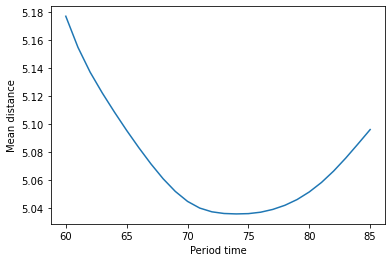

In [14]:
#Plot the mean distance v.s. period time curve.
plt.plot(range(60,86,1),Mean_distance_list_sc)
plt.xlabel("Period time")
plt.ylabel("Mean distance")

In [15]:
#Apply the best period (74) to make the result table
Result = Get_peak_time_and_distance(DataFrame = df_sc, period = 74, bin_time = 1)[0]
Result.to_csv('result.table.csv')

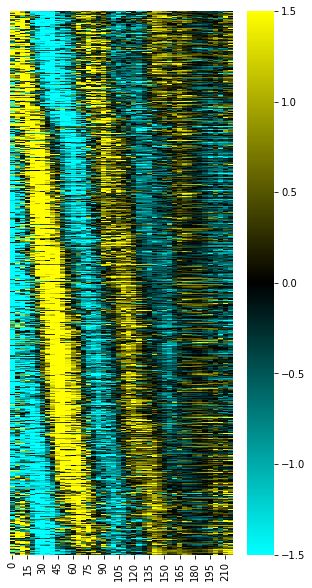

In [17]:
#Plot the heatmap of the Top 1000 periodic genes
Result_df1 = Result.head(1000)
Result_df1 = Result_df1.sort_values(by=['peak_time'])
gene_list = list(Result_df1.index)
plt.figure(figsize = (5, 10))
heatmap_order(df_sc,gene_list,yticks = False, z_score_norm = True,cbar_bool = True)
Result_df1.to_csv('Sc_top1000_period_genes.csv')